# Convolutional Neural Network (CNN) in TensorFlow with Keras
This is a sample pipeline for CNN study in TensorFlow using high level APIs provided by Keras. The pipeline can be used for greyscale or RGB images (here we use MNIST and cifar10 data as examples).

First we import all the dependencies. Keras is now part of TensorFlow (version 1.3 and above), so we can call its APIs via TensorFlow without installing Keras. 

In [1]:
from tensorflow.contrib.keras.api.keras.models import Sequential
from tensorflow.contrib.keras.api.keras.layers import (
        Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU)
from tensorflow.contrib.keras.api.keras.datasets import cifar10, mnist
from tensorflow.contrib.keras.api.keras.utils import to_categorical 
from tensorflow.contrib.keras.api.keras.optimizers import (Adagrad, Adam) 
from tensorflow.contrib.keras.api.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os

We now define all the functions typically required for image recognition study using CNN.

In [2]:
def display_image(x,y,label,column_no=10,title='Your title here'):
    #only supply 2D array if image has 1 channel
    x = np.reshape(x,(len(x),img_rows, img_cols)) if channel_no == 1 else x
    
    plt.figure(figsize=(10,10))
    row_no = np.around(len(y)/column_no).astype(int)
    for i in range(len(y)):
        plt.subplot(row_no,column_no,i+1)
        plt.imshow(x[i], cmap='Greys')
        plt.title(str(label[y[i]]))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

def preprocess_data():
    
    '''data pre-processing'''
    # the data, shuffled and split between train and test sets
    (x, y), (x_test, y_test) = data
    # further split to train and validation set using train_test_split function from sklearn 
    # (to provide random shuffle and split)
    x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.3, random_state=43)

    #reshape data to fit Tensorflow format
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channel_no)
    x_validate = x_validate.reshape(x_validate.shape[0], img_rows, img_cols, channel_no)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channel_no)

    input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype('float32')
    x_validate = x_validate.astype('float32')
    x_test = x_test.astype('float32')

    #normalise values of input data to be in 0-1 range
    x_train /= 255
    x_validate /= 255
    x_test /= 255

    #one-hot encoding
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
    y_validate = to_categorical(y_validate, num_classes)
    
    print('*******************************')
    print('PRE-PROCESSING DATA')
    print('Raw data shape:')
    print('Training input =', x_train.shape)
    print('Training output =', y_train.shape)
    print('Validation input =', x_validate.shape)
    print('Validation output =', y_validate.shape)
    print('Test input =', x_test.shape)
    print('Test output =', y_test.shape)
    print('*******************************')

    return x_train, y_train, x_validate, y_validate, x_test, y_test

def inverse_one_hot(y):
    
    '''a rather stupid way to inverse one-hot-encoding'''
    y_inv = np.zeros(y.shape[0])
    for i in range(y_train.shape[0]):
        y_inv[i] = np.argmax(y[i,:])
        
    return y_inv.astype(int)

def setup_network(model_type='default'):
    
    if model_type=='default':
        #set CNN layers
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3,3),
                         activation='relu',
                         input_shape=x_train.shape[1:] ))

        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.5))
        model.add(Flatten())

        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))

        model.add(Dense(num_classes, activation='softmax'))

        model.compile(loss=categorical_crossentropy,
                      optimizer=Adam(),
                      metrics=['accuracy'])

        model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_validate, y_validate))
    
    elif model_type=='modified':
        
        model = Sequential()
        
        model.add(Conv2D(16, kernel_size=(3,3),
                         activation='relu',
                         input_shape=x_train.shape[1:] ))
        
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(LeakyReLU(alpha=0.3))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.1))
        
       
        model.add(Flatten())

        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.25))

        model.add(Dense(num_classes, activation='softmax'))

        model.compile(loss=categorical_crossentropy,
                      optimizer=Adagrad(),
                      metrics=['accuracy'])

        history = model.fit(x_train, y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              verbose=1,
                              validation_data=(x_validate, y_validate))     
       
    return model, history

def monitor_performance(history):
    
    plt.figure()
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

Define the data and preprocess it.

*******************************
PRE-PROCESSING DATA
Raw data shape:
Training input = (35000, 32, 32, 3)
Training output = (35000, 10)
Validation input = (15000, 32, 32, 3)
Validation output = (15000, 10)
Test input = (10000, 32, 32, 3)
Test output = (10000, 10)
*******************************


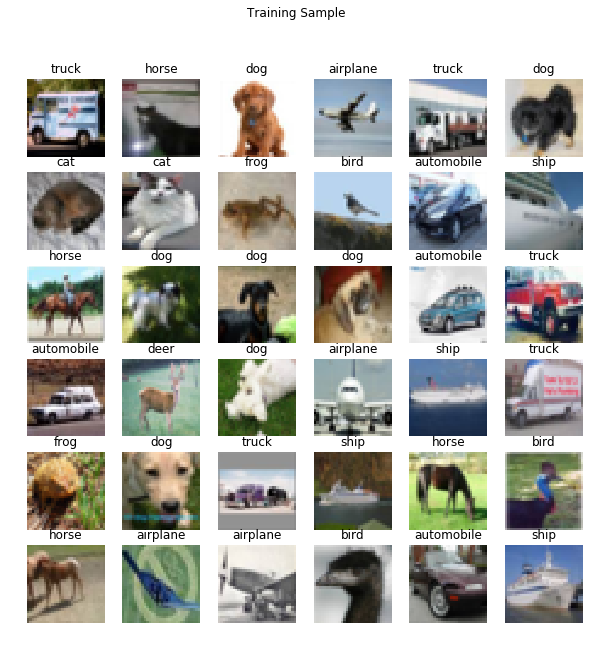

In [3]:
case = 'cifar10'

# input image dimensions
if case == 'cifar10':
    img_rows, img_cols = 32, 32
    label = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
    data = cifar10.load_data()
    channel_no = 3
    num_classes = 10
elif case == 'mnist':
    img_rows, img_cols = 28, 28
    label = np.arange(0,10,1)
    data = mnist.load_data()
    channel_no = 1
    num_classes = 10

x_train, y_train, x_test, y_test, x_validate, y_validate = preprocess_data()
y_train_inv = inverse_one_hot(y_train)
display_image(x_train[:36],y_train_inv[:36],label,6, 'Training Sample')

Setup and run the network.

Train on 35000 samples, validate on 10000 samples
Epoch 1/25
35000/35000 [==============================] - 88s - loss: 1.9436 - acc: 0.2812 - val_loss: 1.5045 - val_acc: 0.4504
Epoch 2/25
35000/35000 [==============================] - 87s - loss: 1.4108 - acc: 0.4860 - val_loss: 1.2861 - val_acc: 0.5359
Epoch 3/25
35000/35000 [==============================] - 89s - loss: 1.2208 - acc: 0.5638 - val_loss: 1.1142 - val_acc: 0.5986
Epoch 4/25
35000/35000 [==============================] - 93s - loss: 1.1008 - acc: 0.6091 - val_loss: 1.0178 - val_acc: 0.6402
Epoch 5/25
35000/35000 [==============================] - 91s - loss: 1.0196 - acc: 0.6444 - val_loss: 0.9746 - val_acc: 0.6597
Epoch 6/25
35000/35000 [==============================] - 87s - loss: 0.9539 - acc: 0.6627 - val_loss: 1.0381 - val_acc: 0.6329
Epoch 7/25
35000/35000 [==============================] - 93s - loss: 0.9075 - acc: 0.6809 - val_loss: 0.9120 - val_acc: 0.6800
Epoch 8/25
35000/35000 [==============================

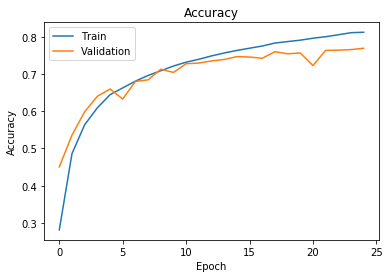

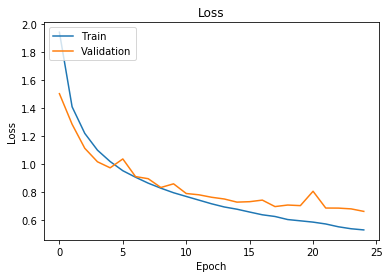

Test loss: 0.646, Test accuracy:  77.71%


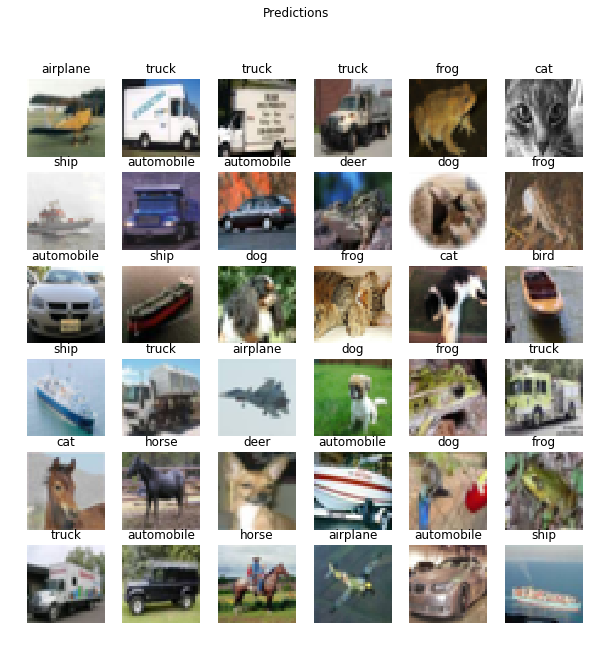

****END****


In [4]:
batch_size = 128
epochs = 25
    
model, history = setup_network('modified')
monitor_performance(history)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {:.3f}, Test accuracy:  {:.2f}%'.format(score[0],score[1]*100))

prediction = model.predict_classes(x_test, verbose=0)
display_image(x_test[:36], prediction[:36],label,6, 'Predictions')
print('****END****')